## Libraries

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import math
import requests
from itertools import combinations
import seaborn as sns
pd.set_option('display.max_colwidth', None)

## Dataset - company aspects by firm

In [45]:
df = pd.read_csv("Final_company_aspect_matrix_with_counts.csv")
len(df)

4618

In [46]:
df.head()

,firm,aspect,avg_star_rating,n_mentions
0,AFH Wealth Management,culture,2.769231,13
1,AFH Wealth Management,growth & learning,3.444444,9
2,AFH Wealth Management,hr & recruitment,2.521739,23
3,AFH Wealth Management,job role clarity,1.000000,4
4,AFH Wealth Management,job security,1.400000,5


## EDA for company aspects

In [47]:
df['n_mentions'].min(), df['n_mentions'].max()

(1, 1237)

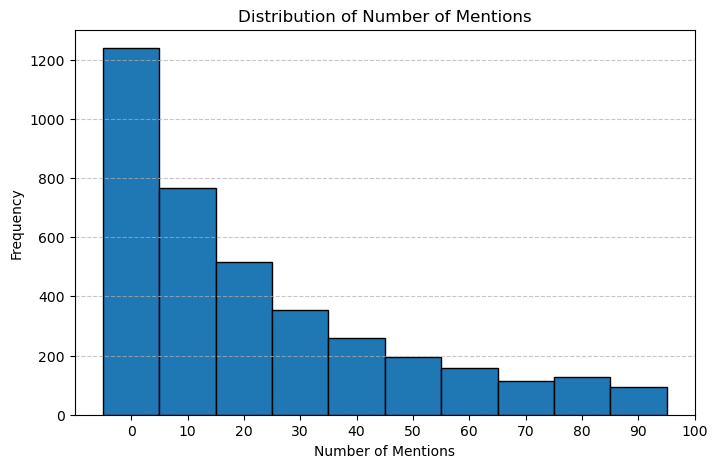

In [48]:
bins = list(range(0, 110, 10))

plt.figure(figsize=(8,5))
plt.hist(df['n_mentions'], bins=bins, edgecolor='black', align='left')
plt.title('Distribution of Number of Mentions')
plt.xlabel('Number of Mentions')
plt.ylabel('Frequency')
plt.xticks(bins)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


The distribution of the number of times an aspect has been mentioned for a specific company is **highly left-skewed**. 

In [49]:
companies_count = len(df.groupby('firm'))
print(f'Currently the dataset consists of {companies_count} companies')

Currently the dataset consists of 295 companies


In [50]:
mentions_count = df.groupby('firm')['n_mentions'].sum()
mentions_count = mentions_count.sort_values(ascending=False)

Top 20 companies by total number of aspect mentions:

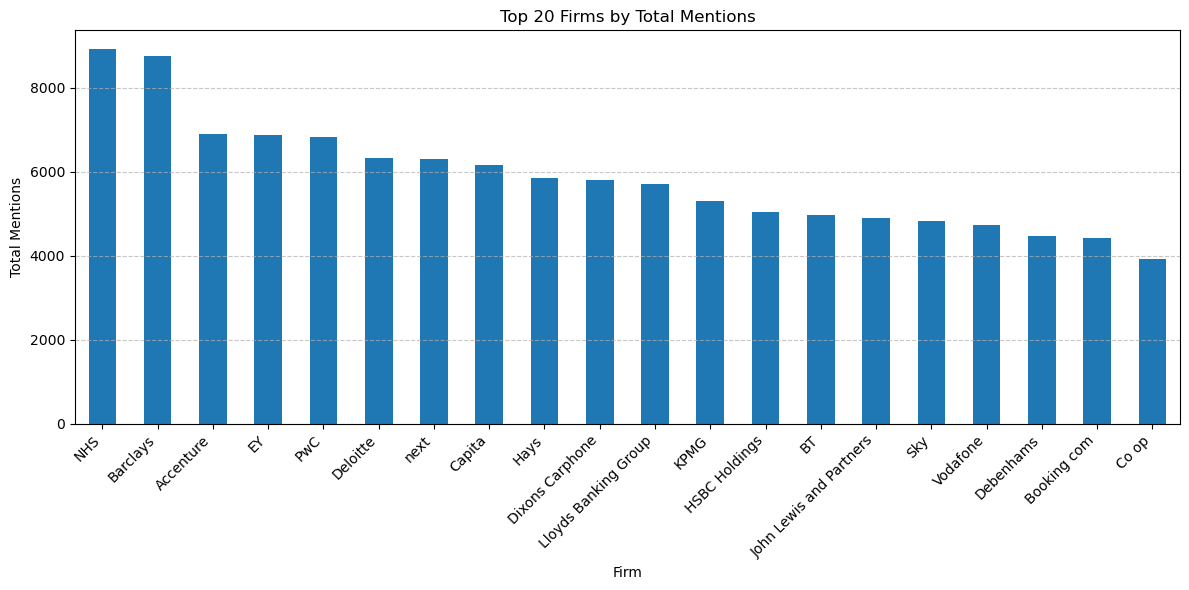

In [51]:
mentions_count.head(20).plot(kind='bar', figsize=(12, 6))
plt.title("Top 20 Firms by Total Mentions")
plt.xlabel("Firm")
plt.ylabel("Total Mentions")
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


In [52]:
mentions_count[mentions_count<5]

firm
Office of Rail Regulation    3
Health Protection Agency     2
UKCIL                        1
Tengizchevroil               1
Name: n_mentions, dtype: int64

In [53]:
len(mentions_count[mentions_count<5])

4

There are 16 companies for which the total number of mentions of all aspects is below 5.

In [54]:
df['aspect'].nunique()

17

There are **18 unique aspects** in the dataset.

Total number of mentions per aspect:

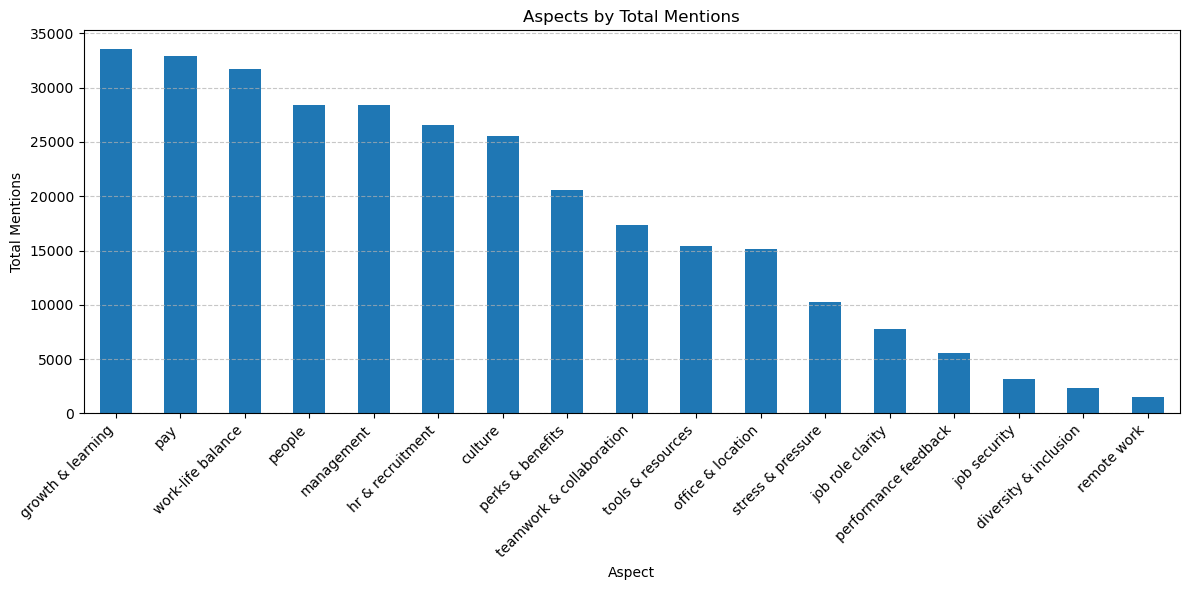

In [55]:
aspect_mentions = df.groupby('aspect')['n_mentions'].sum().sort_values(ascending=False)

plt.figure(figsize=(12, 6))
aspect_mentions.plot(kind='bar')
plt.title(f"Aspects by Total Mentions")
plt.xlabel("Aspect")
plt.ylabel("Total Mentions")
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

The **TOP 5 most commonly mentioned aspects** are:
- people
- growth
- pay
- work-life balance
- management

The **TOP 5 most rarely mentioned aspects** are:
- travel
- performance feedback
- diversity & inclusion
- remote work
- job security

In [56]:
# Count number of aspects per firm
aspect_count = df.groupby('firm')['aspect'].count().reset_index(name='n_aspects')
aspect_count.sort_values('n_aspects', ascending=False)

,firm,n_aspects
147,J P Morgan,17
165,Leaders Romans Group,17
150,JP Boden and Co,17
151,Jaguar Land Rover,17
153,John Lewis and Partners,17
...,...,...
292,i Net Solution,4
198,Office of Rail Regulation,3
135,Health Protection Agency,1
270,UKCIL,1


In [57]:
aspect_count[aspect_count['n_aspects']<5]

,firm,n_aspects
135,Health Protection Agency,1
198,Office of Rail Regulation,3
252,Tengizchevroil,1
270,UKCIL,1
292,i Net Solution,4


In [58]:
len(aspect_count[aspect_count['n_aspects']<5])

5

There are 17 companies for which the number of detected, different aspects is below 5.

In [59]:
# number of companies having >= 10 aspects:
firms_10 = aspect_count[aspect_count['n_aspects'] >= 10]
len(firms_10)

280

There are 231 companies having more than 10 different aspects detected.

In [60]:
# number of total reviews for those companies:
list_of_companies = list(firms_10['firm'])
print('Those companies are:')
print(list_of_companies)

Those companies are:
['AFH Wealth Management', 'AJ Bell', 'ASOS', 'AXA UK', 'Abcam', 'Accenture', 'Accor', 'Achieving for Children', 'ActionCOACH', 'Active Care Group', 'Adecco', 'Age UK The National Charity', 'AlixPartners', 'American Express', 'Amey', 'Angard Staffing', 'Anglian Water', 'Anglo American', 'Animal and Plant Health Agency', 'Aon', 'Apple', 'Arcadia', 'Arnold Clark', 'AstraZeneca', 'Aviva', 'BAT', 'BBC', 'BDO', 'BHS', 'BIS', 'BNP Paribas', 'BNY Mellon', 'BPP Holdings', 'BT', 'Babcock International Group', 'Babylon Health', 'Bain and Company', 'Balfour Beatty', 'Bannatyne Group', 'Barchester Healthcare', 'Barclays', 'Barnardo s', 'Barnet and Chase Farm Hospitals NHS Trust', 'Barnett Waddingham', 'Barratt Developments', 'Barts Health NHS Trust', 'Bayer', 'Bloomberg L P', 'Blue Arrow', 'Blue Yonder', 'Booking com', 'Boston Consulting Group', 'Brewin Dolphin', 'British Red Cross', 'Brook Street', 'Bullhorn', 'Bupa', 'CBRE', 'Cambridge Assessment', 'Capita', 'Capital Group', 

Finding the **minimum aspect threshold** for companies:

In [61]:
def find_min_aspect_threshold(min_shared=11):
    for threshold in range(min_shared, 19):  
        # 18 is the upper bound as maximum number of aspects detected for a company is 18
        firm_aspects = df.groupby("firm")["aspect"].apply(set)
        firm_aspects = firm_aspects[firm_aspects.apply(len) >= threshold]

        all_share_enough = True
        for firm1, aspects1 in firm_aspects.items():
            for firm2, aspects2 in firm_aspects.items():
                if firm1 == firm2:
                    continue
                if len(aspects1.intersection(aspects2)) < min_shared:
                    all_share_enough = False
                    break
            if not all_share_enough:
                break

        if all_share_enough:
            # Find aspects shared by all qualifying firms
            shared_aspects = set.intersection(*firm_aspects.values)
            print(f"Minimum aspect threshold for each company: {threshold}")
            print(f"Number of qualifying firms: {len(firm_aspects)}")
            print(f"Number of aspects shared by ALL qualifying firms: {len(shared_aspects)}")
            print(f"Shared aspects:\n{sorted(shared_aspects)}")
            companies = firm_aspects.index.tolist()
            return threshold, firm_aspects, shared_aspects, companies

    print("No threshold found where all firms share the required number of aspects.")
    return None

In [62]:
threshold, firm_aspects, shared_aspects, qualifying_companies = find_min_aspect_threshold(min_shared=11)
print(qualifying_companies)


Minimum aspect threshold for each company: 14
Number of qualifying firms: 269
Number of aspects shared by ALL qualifying firms: 10
Shared aspects:
['culture', 'growth & learning', 'hr & recruitment', 'management', 'office & location', 'pay', 'people', 'perks & benefits', 'tools & resources', 'work-life balance']
['AFH Wealth Management', 'AJ Bell', 'ASOS', 'AXA UK', 'Abcam', 'Accenture', 'Accor', 'ActionCOACH', 'Active Care Group', 'Adecco', 'Age UK The National Charity', 'AlixPartners', 'American Express', 'Amey', 'Anglian Water', 'Anglo American', 'Animal and Plant Health Agency', 'Aon', 'Apple', 'Arcadia', 'Arnold Clark', 'AstraZeneca', 'Aviva', 'BAT', 'BBC', 'BDO', 'BHS', 'BIS', 'BNP Paribas', 'BNY Mellon', 'BPP Holdings', 'BT', 'Babcock International Group', 'Babylon Health', 'Bain and Company', 'Balfour Beatty', 'Bannatyne Group', 'Barchester Healthcare', 'Barclays', 'Barnardo s', 'Barnett Waddingham', 'Barratt Developments', 'Barts Health NHS Trust', 'Bayer', 'Bloomberg L P', 'B

In [63]:
def find_max_shared_aspects_group(df,
                                  min_aspects_per_firm=1,
                                  min_group_size=1):
    # 1) Build a dict: firm → set of its aspects
    firm_aspects = df.groupby("firm")["aspect"].apply(set).to_dict()
    # 2) Filter out firms with too few aspects
    firms = [f for f, s in firm_aspects.items() if len(s) >= min_aspects_per_firm]

    best_group = []
    best_shared = set()

    # 3) For each firm, try to build the largest‐intersection group
    for start in firms:
        group = [start]
        shared = firm_aspects[start].copy()
        remaining = set(firms) - {start}

        # Greedily add the firm that gives the largest intersection
        while True:
            # find candidate + its new shared set
            cand, cand_shared = max(
                ((f, shared & firm_aspects[f]) for f in remaining),
                key=lambda x: len(x[1]),
                default=(None, set())
            )
            # stop if no positive intersection
            if cand is None or not cand_shared:
                break
            # else add it and continue
            group.append(cand)
            shared = cand_shared
            remaining.remove(cand)

        # record if this start yields a better “shared” set
        if len(shared) > len(best_shared) and len(group) >= min_group_size:
            best_shared = shared.copy()
            best_group = group.copy()

    print(f"Best group size: {len(best_group)}")
    print(f"Number of shared aspects: {len(best_shared)}")
    print(f"Shared aspects: {sorted(best_shared)}")
    return best_group, best_shared


In [64]:
group, shared = find_max_shared_aspects_group(df,
                                              min_aspects_per_firm=14,
                                              min_group_size=100)

Best group size: 269
Number of shared aspects: 10
Shared aspects: ['culture', 'growth & learning', 'hr & recruitment', 'management', 'office & location', 'pay', 'people', 'perks & benefits', 'tools & resources', 'work-life balance']


#### Arzum Common Aspect Finder

## Arzum Aspect Finder Ends

## Using the right dataset

In [1]:
import pandas as pd

# 1) Load the full aspect matrix
df = pd.read_csv("Final_company_aspect_matrix_with_counts.csv")

# 2) Build firm → set of all aspects it mentions
firm2asets = df.groupby("firm")["aspect"].apply(set)

# 3) Get the universe of aspects
all_aspects = set(df["aspect"].unique())

# 4) Count, for each firm, how many aspects it's MISSING
missing_counts = firm2asets.apply(lambda s: len(all_aspects - s))

# 5) Filter to those missing ≤ 2 aspects
kept_firms = missing_counts[missing_counts <= 2].index

# 6) Print how many you’d keep
print(f"Companies kept (missing ≤2 of {len(all_aspects)} aspects): {len(kept_firms)}")

Companies kept (missing ≤2 of 17 aspects): 253


In [ ]:
# 1. Group by aspect, count distinct firms
aspect_company_counts = (
    df
    .groupby("aspect")["firm"]
    .nunique()
    .reset_index(name="n_companies")
)

# 2. (Optional) Sort descending by count
aspect_company_counts = aspect_company_counts.sort_values(
    by="n_companies", ascending=False
)

aspect_company_counts


,aspect,n_companies
9,people,289
8,pay,288
2,growth & learning,288
6,management,287
7,office & location,287
16,work-life balance,287
0,culture,285
3,hr & recruitment,284
15,tools & resources,284
11,perks & benefits,283


In [ ]:
import pandas as pd

# 2) Total firms in your dataset
n_firms = df["firm"].nunique()

# 3) Count how many firms mention each of those 13 aspects
counts = (
    df
      .groupby("aspect")["firm"]
      .nunique()
      .reset_index(name="companies_mentioning")
)

# 4) Compute missing = total firms – mentioning
counts["companies_missing"] = n_firms - counts["companies_mentioning"]

# 5) See the result
counts


,aspect,companies_mentioning,companies_missing
0,culture,285,10
1,diversity & inclusion,226,69
2,growth & learning,288,7
3,hr & recruitment,284,11
4,job role clarity,281,14
5,job security,248,47
6,management,287,8
7,office & location,287,8
8,pay,288,7
9,people,289,6


In [ ]:
counts["companies_missing"].sum()

397

In [9]:
import pandas as pd

# 1. (Re)build firm→set(aspects) and your good_firms index as before:
firm2aspects = df.groupby("firm")["aspect"].apply(set)
# missing_counts_all = firm2aspects.apply(lambda s: len(target_aspects - s))
# good_firms = missing_counts_all[missing_counts_all <= 2].index

# 3. For each aspect, count how many firms lack it:
missing_per_aspect = {
    asp: sum(asp not in s for s in firm2aspects)
    for asp in sorted(list(df['aspect'].unique()))
}

# 4. Turn into a DataFrame and sort:
missing_df = (
    pd.DataFrame.from_dict(missing_per_aspect, orient='index', columns=['missing_count'])
      .reset_index()
      .rename(columns={'index':'aspect'})
      .sort_values('missing_count', ascending=False)
)

missing_df

,aspect,missing_count
12,remote work,109
1,diversity & inclusion,69
5,job security,47
10,performance feedback,38
13,stress & pressure,20
4,job role clarity,14
11,perks & benefits,12
14,teamwork & collaboration,12
15,tools & resources,11
3,hr & recruitment,11


In [10]:
# Filter the long‐form DF to only those 195 firms **and** only the 13 aspects
filtered = df[
    df["firm"].isin(kept_firms) &
    df["aspect"].isin(all_aspects)
]

# Compute the average star rating per aspect
avg_aspect_scores = (
    filtered
      .groupby("aspect")["avg_star_rating"]
      .mean()
      .reset_index(name="average_score")
      .sort_values("average_score", ascending=False)
)

avg_aspect_scores


,aspect,average_score
9,people,3.493328
11,perks & benefits,3.484277
14,teamwork & collaboration,3.431400
1,diversity & inclusion,3.384223
12,remote work,3.292259
15,tools & resources,3.255254
0,culture,3.201313
2,growth & learning,3.178803
16,work-life balance,3.080952
7,office & location,3.048829


/var/folders/q5/sf4jxcsn1yn662lf8jw7kk7c0000gn/T/ipykernel_90910/2942682805.py:10: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(


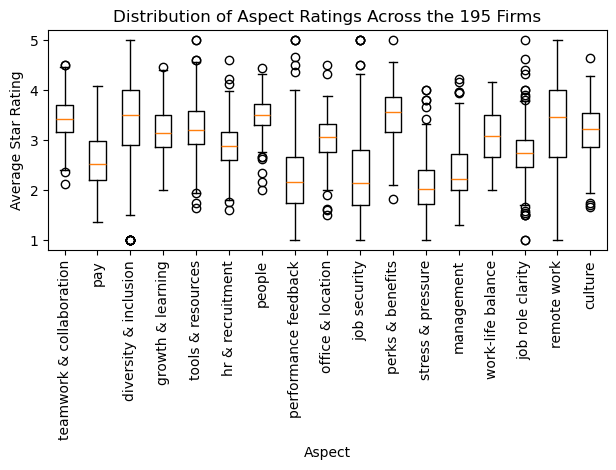

/var/folders/q5/sf4jxcsn1yn662lf8jw7kk7c0000gn/T/ipykernel_90910/2942682805.py:23: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(


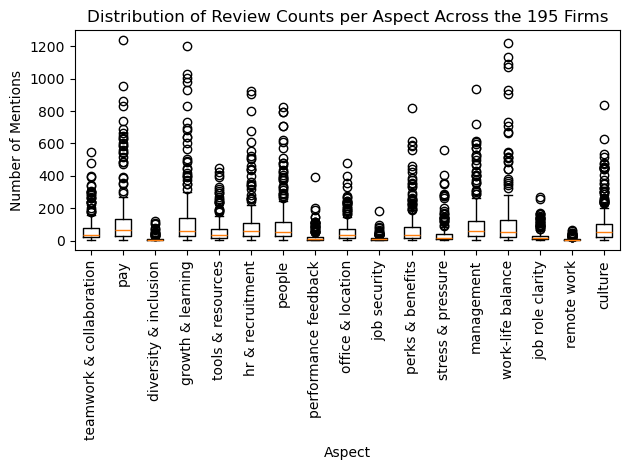

In [16]:
# 4) Filter long-form data to only those firms & those 13 aspects
filtered = df[df["firm"].isin(kept_firms) & df["aspect"].isin(all_aspects)]

# 5) Pivot into two matrices: one for ratings, one for mention counts
ratings_pivot = filtered.pivot(index="firm", columns="aspect", values="avg_star_rating")
counts_pivot  = filtered.pivot(index="firm", columns="aspect", values="n_mentions")

# 6) Box-plot of rating distributions
plt.figure()
plt.boxplot(
    [ratings_pivot[asp].dropna() for asp in all_aspects],
    labels=all_aspects
)
plt.xticks(rotation=90)
plt.xlabel("Aspect")
plt.ylabel("Average Star Rating")
plt.title("Distribution of Aspect Ratings Across the 195 Firms")
plt.tight_layout()
plt.show()

# 7) Box-plot of mention-count distributions
plt.figure()
plt.boxplot(
    [counts_pivot[asp].dropna() for asp in all_aspects],
    labels=all_aspects
)
plt.xticks(rotation=90)
plt.xlabel("Aspect")
plt.ylabel("Number of Mentions")
plt.title("Distribution of Review Counts per Aspect Across the 195 Firms")
plt.tight_layout()
plt.show()


In [17]:
# (Assume df, firm2aspects, missing_counts, total_reviews already defined as before)
total_reviews = df.groupby("firm")["n_mentions"].sum()

# 2) From **those** good firms, pick the ones missing stress & pressure:
kept_missing_stress = [
    f for f in kept_firms
    if "stress & pressure" not in firm2aspects[f]
]

# 3) Build the summary for just those:
summary = pd.DataFrame({
    "firm":           kept_missing_stress,
    "missing_count":  [missing_counts[f] for f in kept_missing_stress],
    "total_reviews":  [total_reviews[f]   for f in kept_missing_stress]
})

print(f"Found {len(summary)} good firms missing ‘stress & pressure’\n")
summary.sort_values("total_reviews", ascending=False)

Found 3 good firms missing ‘stress & pressure’



,firm,missing_count,total_reviews
0,Brewin Dolphin,1,281
1,Career Legal,1,140
2,Square Enix,2,97


In [18]:
# 2) From **those** good firms, pick the ones missing stress & pressure:
kept_missing_clarity = [
    f for f in kept_firms
    if "job role clarity" not in firm2aspects[f]
]

# 3) Build the summary for just those:
summary = pd.DataFrame({
    "firm":           kept_missing_clarity,
    "missing_count":  [missing_counts[f] for f in kept_missing_clarity],
    "total_reviews":  [total_reviews[f]   for f in kept_missing_clarity]
})

print(f"Found {len(summary)} good firms missing ‘job role clarity’\n")
summary.sort_values("total_reviews", ascending=False)

Found 0 good firms missing ‘job role clarity’



,firm,missing_count,total_reviews


Adding this graph that analyzes if companies miss aspects because they have few reviews

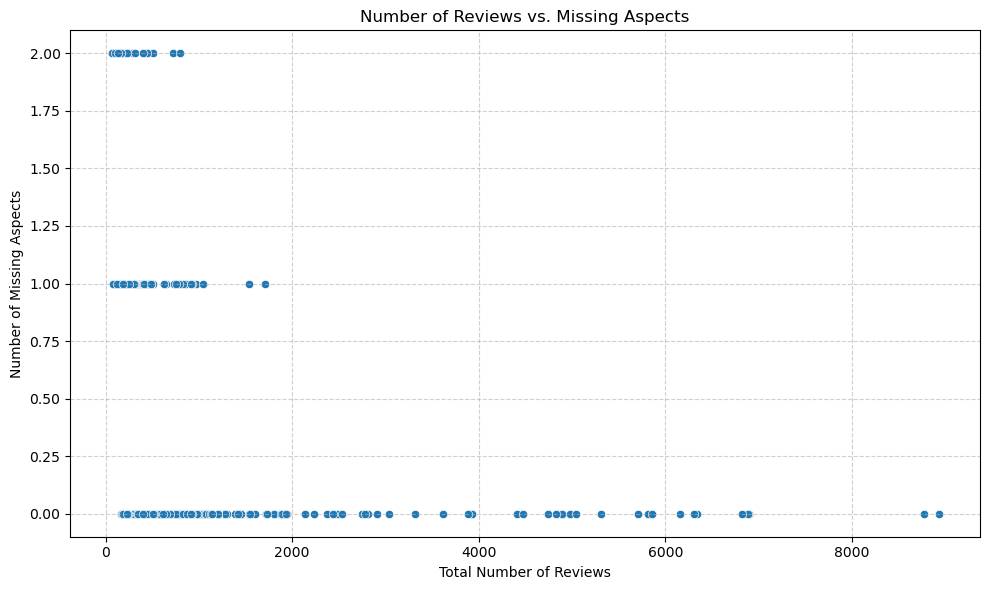

In [19]:
# 1) Restrict both series to the good firms (with ≤ 2 missing aspects)
kept_missing_counts = missing_counts.loc[kept_firms]
kept_total_reviews = df.groupby("firm")["n_mentions"].sum().loc[kept_firms]

# 2) Create a DataFrame for plotting
scatter_df = pd.DataFrame({
    "firm": kept_firms,
    "missing_aspects": kept_missing_counts.values,
    "total_reviews": kept_total_reviews.values
})

# 3) Plot
plt.figure(figsize=(10, 6))
sns.scatterplot(data=scatter_df, x="total_reviews", y="missing_aspects")
plt.title("Number of Reviews vs. Missing Aspects")
plt.xlabel("Total Number of Reviews")
plt.ylabel("Number of Missing Aspects")
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


In [20]:
from scipy.stats import f_oneway

# Group review counts by number of missing aspects (0, 1, 2)
group0 = scatter_df[scatter_df["missing_aspects"] == 0]["total_reviews"]
group1 = scatter_df[scatter_df["missing_aspects"] == 1]["total_reviews"]
group2 = scatter_df[scatter_df["missing_aspects"] == 2]["total_reviews"]

# Run one-way ANOVA
f_stat, p_val = f_oneway(group0, group1, group2)

# Print results with interpretation
print("ANOVA Test: Do firms with different numbers of missing aspects differ in their average number of reviews?\n")
print(f"Means: 0→{group0.mean():.2f}, 1→{group1.mean():.2f}, 2→{group2.mean():.2f}")
print(f"F-statistic: {f_stat:.4f}")
print(f"P-value: {p_val:.4g}")

ANOVA Test: Do firms with different numbers of missing aspects differ in their average number of reviews?

Means: 0→1678.54, 1→449.07, 2→257.43
F-statistic: 23.7179
P-value: 3.701e-10


We are selecting the 13 most common aspects, filtering out the firms that are missing more than 2 of those aspects. Finally, imputing the missing values with the 80% of the average aspect mean:

In [ ]:
# pivot out the 195×13 rating matrix (no imputation yet)
base_mat = (
    df[
        df["firm"].isin(kept_firms) &
        df["aspect"].isin(all_aspects)
    ]
    .pivot(index="firm", columns="aspect", values="avg_star_rating")
)
base_mat = base_mat.reindex(index=kept_firms, columns=all_aspects)

In [23]:
# count missing per column
missing_per_col = base_mat.isna().sum()

# confirm that there are zero missing overall
total_missing = missing_per_col.sum()
print(f"\nTotal missing values in matrix: {total_missing}")


Total missing values in matrix: 128


In [ ]:
# compute 80% of each aspect’s observed mean
aspect_means = base_mat.mean()
fill_values  = aspect_means * 0.8

# impute: NaN → 0.8 × mean
imputed_mat = base_mat.fillna(fill_values)

# Check
print(imputed_mat.shape)
imputed_mat.head()


(253, 17)


aspect,teamwork & collaboration,pay,diversity & inclusion,growth & learning,tools & resources,hr & recruitment,people,performance feedback,office & location,job security,perks & benefits,stress & pressure,management,work-life balance,job role clarity,remote work,culture
firm,,,,,,,,,,,,,,,,,
AFH Wealth Management,2.571429,1.894737,2.707378,3.444444,2.111111,2.521739,3.294118,2.500000,3.142857,1.4,3.000000,2.000000,2.375000,3.166667,1.000000,2.633808,2.769231
AJ Bell,3.290323,2.428571,3.000000,3.250000,3.413793,3.000000,3.438596,2.875000,3.468085,2.8,2.862745,2.928571,2.804878,2.870968,2.125000,4.333333,3.416667
ASOS,2.701987,2.335000,2.944444,2.550360,2.864407,2.807692,3.311787,1.809524,3.285714,1.4,3.685237,2.404040,1.754464,2.644444,2.350877,3.000000,3.209302
AXA UK,3.702703,3.029851,4.250000,3.534091,3.454545,3.192982,3.704225,2.333333,3.057143,2.5,3.953125,1.800000,2.781250,3.730769,3.100000,3.125000,3.543860
Abcam,4.105263,2.418605,4.250000,3.474576,3.833333,3.513514,4.119048,3.400000,3.302632,2.5,3.725000,3.119048,3.530612,4.063830,3.266667,4.750000,4.153846


In [24]:
# count missing per column
missing_per_col = imputed_mat.isna().sum()

# confirm that there are zero missing overall
total_missing = missing_per_col.sum()
print(f"\nTotal missing values in matrix: {total_missing}")


Total missing values in matrix: 0


In [31]:
aspect_cols = [c for c in imputed_mat.columns]

# 3) Melt ratings wide→long
ratings_long = (
    imputed_mat
    .reset_index()
    .melt(id_vars="firm", value_vars=aspect_cols,
          var_name="aspect", value_name="avg_star_rating")
)

# 4) Melt counts wide→long
counts_long = (
    counts_pivot
    .reset_index()
    .melt(id_vars="firm", value_vars=aspect_cols,
          var_name="aspect", value_name="n_mentions")
)

# 5) Merge and fill imputed counts with 0
long_df = (
    ratings_long
    .merge(counts_long, on=["firm","aspect"], how="left")
)
long_df["n_mentions"] = long_df["n_mentions"].fillna(0).astype(int)

# 6) (Optional) sort or re‐order
long_df = long_df.sort_values(["firm","aspect"]).reset_index(drop=True)

# Now `long_df` has the shape you showed:
# Each (firm, aspect) row, with avg_star_rating from imputed_mat,
# and n_mentions = original count or 0 if we had to impute.
long_df.head()


,firm,aspect,avg_star_rating,n_mentions
0,AFH Wealth Management,culture,2.769231,13
1,AFH Wealth Management,diversity & inclusion,2.707378,0
2,AFH Wealth Management,growth & learning,3.444444,9
3,AFH Wealth Management,hr & recruitment,2.521739,23
4,AFH Wealth Management,job role clarity,1.000000,4


In [ ]:
# 9) Save to CSV (optional)
long_df.to_csv(
    "Final_imputed_company_aspect_matrix_with_counts.csv", index=False
)

(4301, 4)


Making sure there are no missing values after the imputation:

There are **160 companies** that share the same **6 aspects**. Those shared aspects are:
- growth, 
- management, 
- people, 
- teamwork & collaboration, 
- tools & resources, 
- work-life balance

/var/folders/q5/sf4jxcsn1yn662lf8jw7kk7c0000gn/T/ipykernel_85709/23582812.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=aspect_mentions.values, y=aspect_mentions.index, palette='Set2')


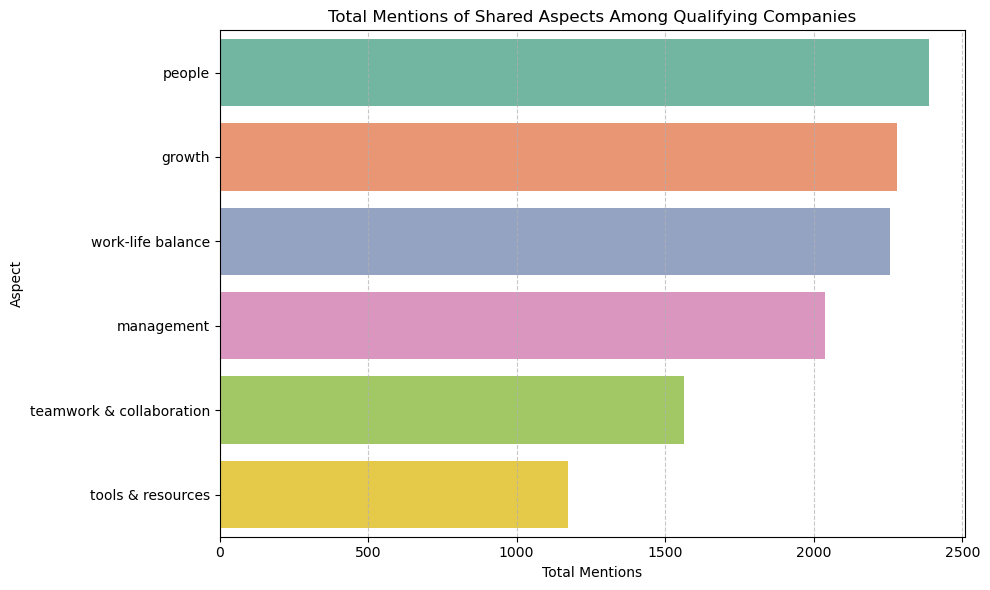

In [ ]:
filtered_df = df[
    (df['firm'].isin(qualifying_companies)) &
    (df['aspect'].isin(shared_aspects))
]

aspect_mentions = filtered_df.groupby('aspect')['n_mentions'].sum().sort_values(ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x=aspect_mentions.values, y=aspect_mentions.index, palette='Set2')

plt.title("Total Mentions of Shared Aspects Among Qualifying Companies")
plt.xlabel("Total Mentions")
plt.ylabel("Aspect")
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

**TOP 9** (the highest total number of mentions of all shared aspects) companies with number of mentions for each shared aspect:

/var/folders/q5/sf4jxcsn1yn662lf8jw7kk7c0000gn/T/ipykernel_85709/2050994531.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=aspect_sum.values, y=aspect_sum.index, ax=ax, palette='Set2')
/var/folders/q5/sf4jxcsn1yn662lf8jw7kk7c0000gn/T/ipykernel_85709/2050994531.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=aspect_sum.values, y=aspect_sum.index, ax=ax, palette='Set2')
/var/folders/q5/sf4jxcsn1yn662lf8jw7kk7c0000gn/T/ipykernel_85709/2050994531.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=aspect_sum.values, y=aspect_su

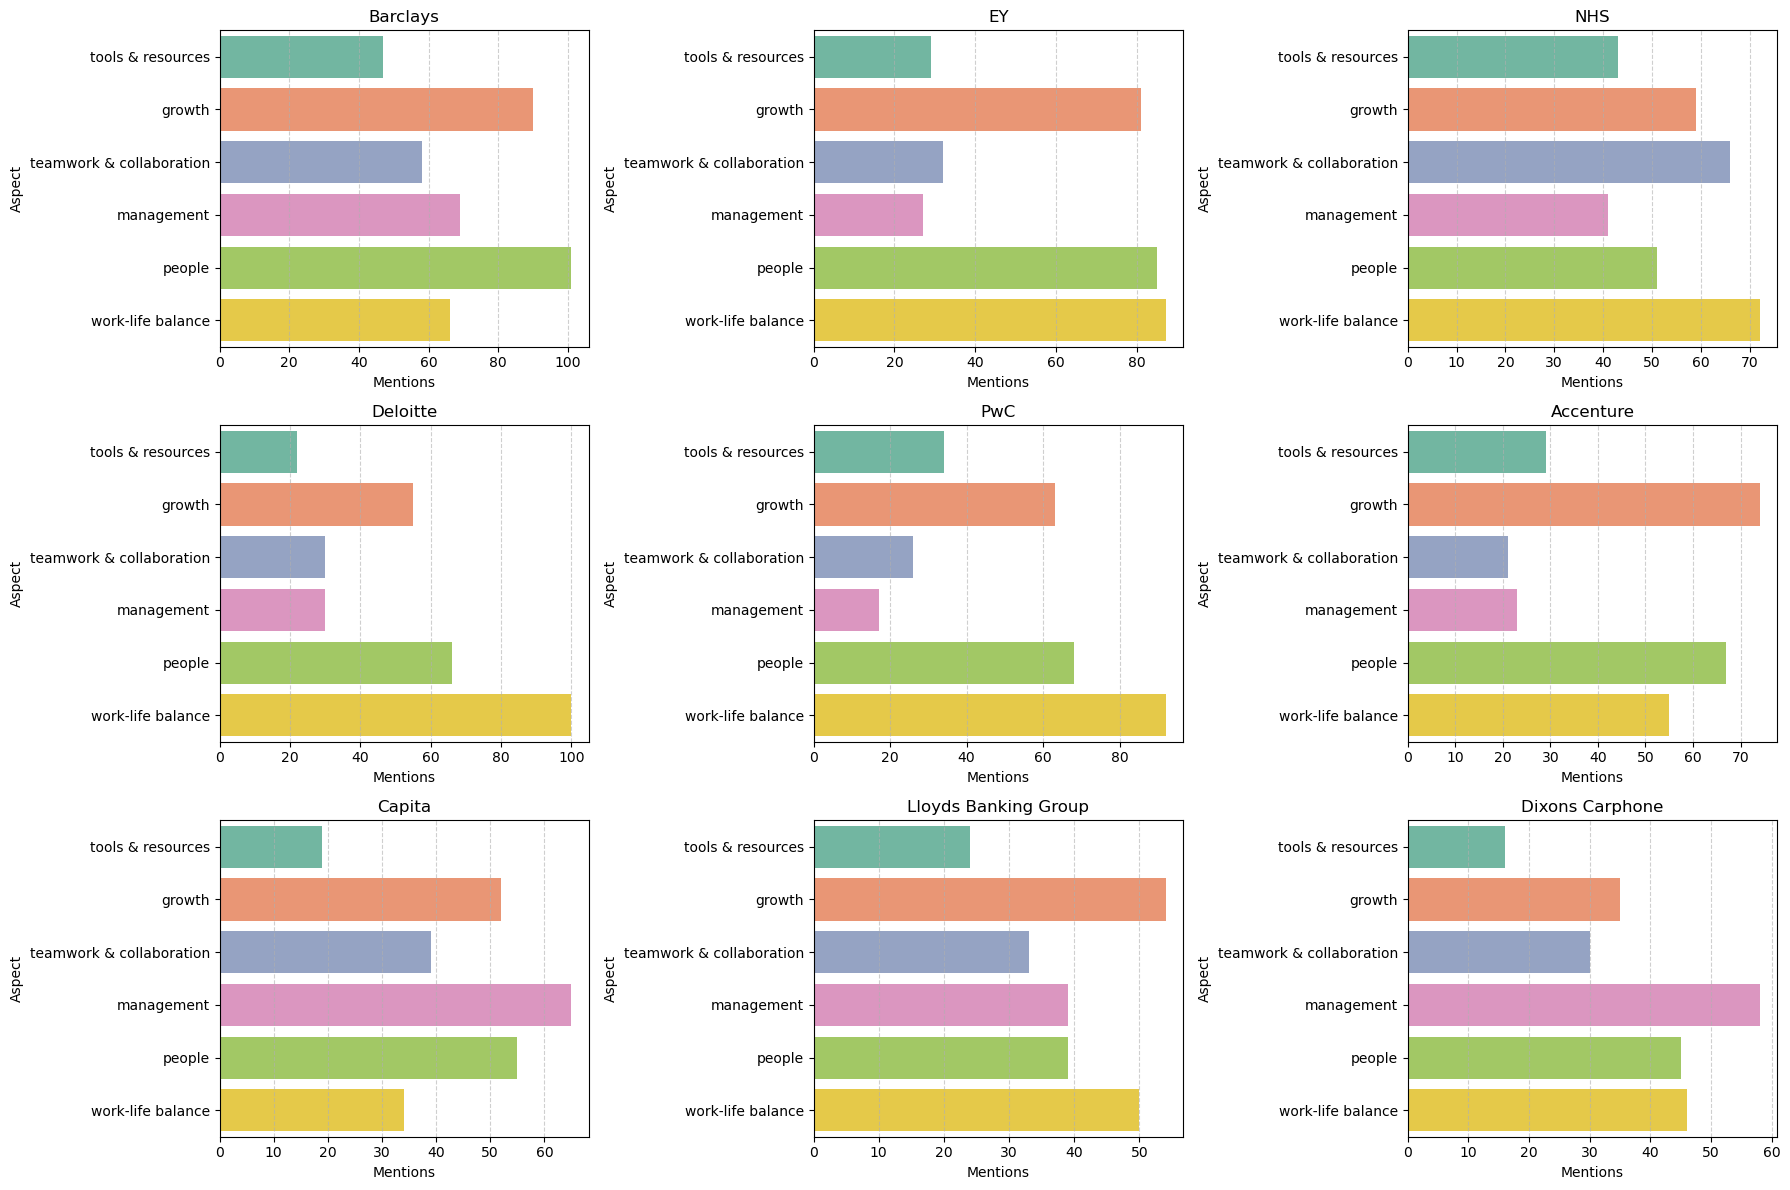

In [ ]:
top_firms = (
    df[df['aspect'].isin(shared_aspects)]
    .groupby('firm')['n_mentions']
    .sum()
    .sort_values(ascending=False)
    .head(9)
    .index
)

filtered_df = df[
    (df['firm'].isin(top_firms)) &
    (df['aspect'].isin(shared_aspects))
]

fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(18, 12))
axes = axes.flatten()

for i, firm in enumerate(top_firms):
    ax = axes[i]
    firm_data = filtered_df[filtered_df['firm'] == firm]
    aspect_sum = firm_data.groupby('aspect')['n_mentions'].sum().reindex(shared_aspects)

    sns.barplot(x=aspect_sum.values, y=aspect_sum.index, ax=ax, palette='Set2')
    ax.set_title(f"{firm}")
    ax.set_xlabel("Mentions")
    ax.set_ylabel("Aspect")
    ax.grid(axis='x', linestyle='--', alpha=0.6)

# Remove empty subplots (if any)
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

## Filtering out companies from the dataset with summarizations by company

In [ ]:
df_to_filter = pd.read_csv('company_merged_summaries.csv')

In [ ]:
df_filtered = df_to_filter[df_to_filter['firm'].isin(qualifying_companies)]
len(df_filtered)

130

Creating the final dataset with all summarizations:

In [ ]:
df_filtered.to_csv('firms_filtered_summarized.csv', index=False)